# Дискриминантный анализ неоднородных данных

## Цели

Имея классифицированную обучающую выборку с помощью дискриминантного анализа и других алгоритмов классифицировать многомерные неоднородные данные.

## Постановка задачи

Для данных Фишера:
1) Провести предварительный анализ кластерной структуры в данных;
2) Провести дискриминантный анализ данных;
3) При помощи других алгоритмов классификации с классифицироанной обучающей выборки классифицировать данные;
4) Провести сравнительный анализ полученных результатов.

*Указание*: использовать выборку из смеси распределений для всех переменных; для обучения и экзамена использовать выборки из различных классов в пропорциях 80% и 20%, либо процедуру кросс-валидации в тех же пропорциях; использовать алгоритмы: ЛДА, КДА, деревья решений CART и др.

## Введение

Будем пользоваться следующими методами: линейный параметрический дискриминантный анализ, квадратичный дискриминантный анализ, классификационные деревья решений, метод k ближайших соседей, наивный байесовский классификатор. Предварительно проведём исследование выборки на наличие кластерной
структуры (ожидается наличие трёх кластеров, согласно постановке задачи)

# Результаты исследований

## Подключение необходимых библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree, DecisionTreeClassifier


from scipy import stats
from scipy.stats import norm, skew, kurtosis, shapiro, chisquare, gaussian_kde, kstest, ttest_ind, spearmanr
from statistics import correlation
import statsmodels.api as sm

Выведем матрицу "объект-признак". В первых четырех столбцах находятся наши независимые переменные sepallen, sepalwid, petallen, petalwid, по которым мы будем проводить классификацию, 5-ом и 6-ом столбцах находятся метки классов для соответвутющих объектов, то есть зависимые переменные, которые мы будем предсказывать.

In [2]:
dataset = datasets.load_iris()

ext_target = dataset.target[:, None]
iris_data_frame = pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=['sepallen', 'sepalwid', 'petallen', 'petalwid', 'target_label', 'target_name'])
iris_data_frame

,sepallen,sepalwid,petallen,petalwid,target_label,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


## Предварительный анализ

Случайную выборку образуют все 3 типа ириса. Зависимой переменной будет являться метка класса target_label, а независимыми - sepallen, sepalwid, petallen, petalwid. Рассмотрим матрицу диаграмм рассеяния для выявления наличия кластерной структуры.

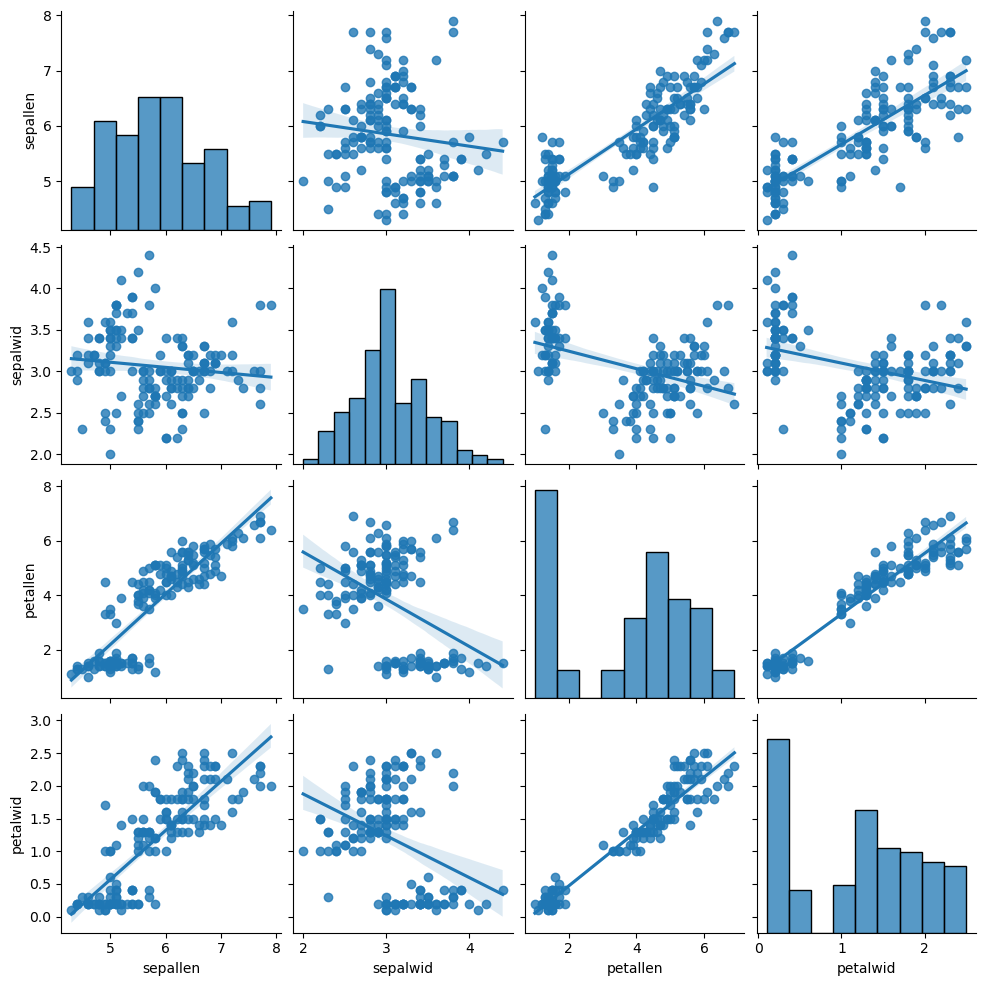

In [4]:
sns.pairplot(data=iris_data_frame[['sepallen', 'sepalwid', 'petallen', 'petalwid']].astype(float), 
             kind='reg', diag_kind='auto')
None

Матричный график рассеяния позволяет увидеть наличие как минимум двух кластеров как из диаграмм рассеяния, так и из гистограмм, где можно пронаблюдать наличие двух вершин. Однако нам известно заранее, что в наших исходных данных действительно имеются кластеры. Но не 2, а 3. Для того, чтобы явно это заметить, раскрасим в матрице рассеяний кластеры.

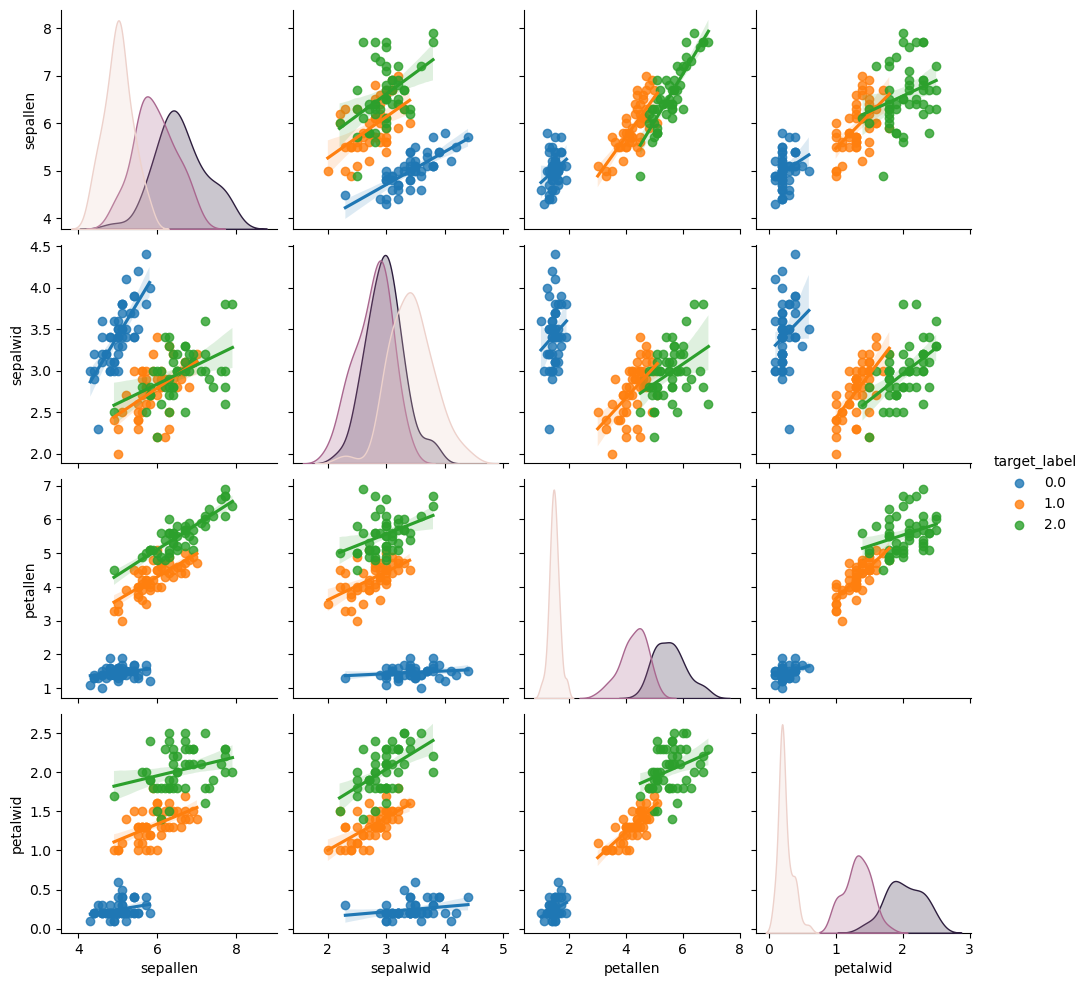

In [5]:
sns.pairplot(data=iris_data_frame[['sepallen', 'sepalwid', 'petallen', 'petalwid', 'target_label']].astype(float), 
             kind='reg', diag_kind='auto', vars=iris_data_frame.columns[:-2], hue='target_label')
None

Заметно, что кластер setosa будет хорошо отделим от остальных двух по всем переменным, поэтому можем предполагать, что все алгоритмы будут хорошо справляться с отделением setosa от двух других кластеров. Кластеры virginica от versicolor могут быть отделимы по переменным petallen, petalwid лучше, чем по sepallen и sepalwid, где, как можно заметить, кластеры "налазят" друг на друга.

Для дальнейшего исследования разобъем выборку на обучающую и тестовую. Как и было указано ранее, 80% выборки будет предоставлено моделям для обучения, а 20% --- для классификации и проверки точности модели.

In [5]:
X = iris_data_frame[['sepallen', 'sepalwid', 'petallen', 'petalwid']].astype(float)
y = iris_data_frame['target_label'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Применение алгоритмов кластеризации в задаче обучения с классифицированной выборкой

Начнем с рассмотрения моделей дискриминантного анализа для классификации неоднородных данных.

### Линейный дискриминантный анализ

Создадим класс модели и сделаем fit-predict для обучения модели и последующего предсказания метки класса.

In [6]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Вычислим показатель accuracy, который будет отображать точность наших предсказаний на тестовой выборке, по формуле
$$accuracy = \dfrac{1}{n} \sum\limits_{i=1}^n [y_{test}^{(i)} =y_{pred}^{(i)}]$$

In [7]:
accuracy_score = sum((y_pred==y_test)) / y_test.size
accuracy_score

1.0

Получили accuracy = 1 на тестовой выборке, что является очень хорошим результатом. Проверим точность нашей модели и с помощью кросс-валидации.

In [8]:
cv=cross_val_score(clf, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print(np.mean(cv))

0.9800000000000001


На кросс валидации наша модель показала среднюю точность 0.98, что также является вполне хорошим результатом. Графически отобразим результаты классификации нашей модели.

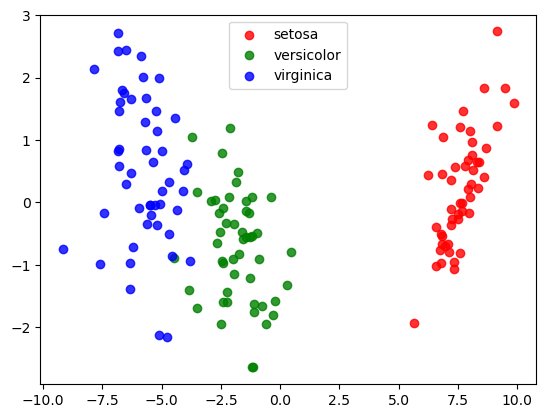

In [9]:
data=clf.fit(X,y).transform(X)
plt.figure()
colors = ['red', 'green', 'blue']
lw = 2
for color, i, label in zip(colors, [0,1,2], ['setosa', 'versicolor', 'virginica']):
    plt.scatter(data[y==i, 0], data[y==i, 1], alpha=.8, color=color, label=label)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

Как и предполагалось, модель хорошо отделила кластер setosa и чуть хуже virginica и versicolor.

Далее проделаем аналогичные действия для остальных моделей.

### Квадратичный дискриминантный анализ

In [11]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Вычислим accuracy.

In [13]:
accuracy_score = sum((y_pred==y_test)) / y_test.size
accuracy_score

0.9666666666666667

Получили accuracy = 0.97, что является также весьма хорошим результатом, но хуже, чем у ЛДА. Проверим точность нашей модели и с помощью кросс-валидации.

In [19]:
cv=cross_val_score(clf, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print(np.mean(cv))

0.9800000000000001


Получили аналогичный средний score равный 0.98, что также является достаточно хорошим результатом. Следовательно, можем сделать вывод, что модель КДА оказалась не сильно хуже ЛДА. Возможно при другом разделении выборки на обучающую и тестовую, мы бы получили одинаковый accuracy_score. Отсюда можем сделать вывод, что в реальной задаче среди этих двух моделей лучше будет проверить работу обеих и выбрать модель с наилучшим результатом. Очевидно, что в другой задаче алгоритм КДА может проявить себя и лучше, чем алгоритм ЛДА. Особенно важно учитывать тот факт, что в текущей задаче данные достаточно неплохо линейно разделимы, что, вообще говоря, бывает не всегда.

### Наивный байесовский классифаер

Предположим, что все признаки попарно независимы, то есть ковариационная матрица признаков имеет диагональный вид. Тогда КДА эквивалентен алгоритму навиного байесовского классификатора.

In [20]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Аналогично вычислим accuracy на тестовой выборке и на кросс валидации

In [21]:
accuracy_score = sum((y_pred==y_test)) / y_test.size
accuracy_score

1.0

In [22]:
cv=cross_val_score(clf, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print(np.mean(cv))

0.9533333333333334


Как можно видеть, в отличие от КДА, на тестовой выборке результат оказался лучше, но на кросс валидации немного хуже. Так что, если признаки попарно независимы, то можно попробовать применить и КДА, и наивного байеса и выбрать модель с лучшим результатом. Но предположение о независимости признаков обязательно на практике должно подкрепляться дополнительными исследованиями.

### Метод k ближайших соседей

Возьмем метод k ближайших соседей с параметром $k=10$. Число соседей мы могли бы задать и другое, однако при таком значении мы можем получить наилучшие показатели точности.

In [14]:
n_neighbors = 10
clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Рассчитаем accuracy.

In [15]:
accuracy_score = sum((y_pred==y_test).astype(float)) / y_test.size
accuracy_score

1.0

Результат на тестовой выборке совпал с предыдущими классификаторами.

In [16]:
cv=cross_val_score(clf, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print(np.mean(cv))

0.9800000000000001


Получили аналогичный результат аналогичный ЛДА. То есть в данной задаче оба алгоритма справились одинаково хорошо. Однако в пользу алгоритма ЛДА можно добавить тот факт, что в нем нам не нужно было задавать гиперпараметров. Мы сразу получили хороший результат.

### Дерево решений

Построим представление дерева решений в виде графа, взяв максимально возможную глубину дерева равную 7.

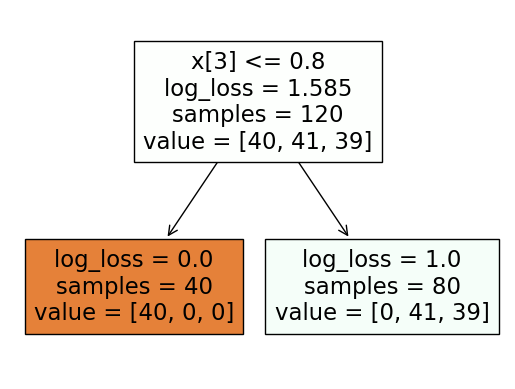

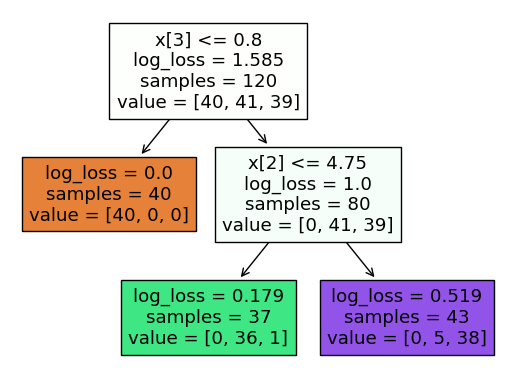

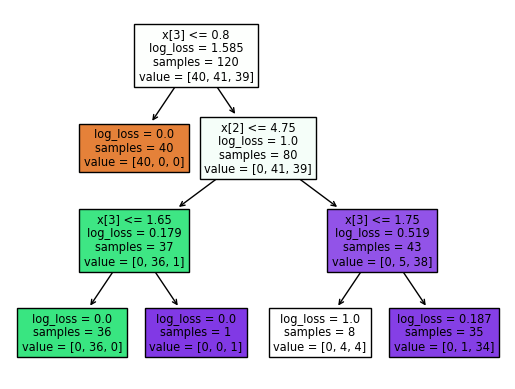

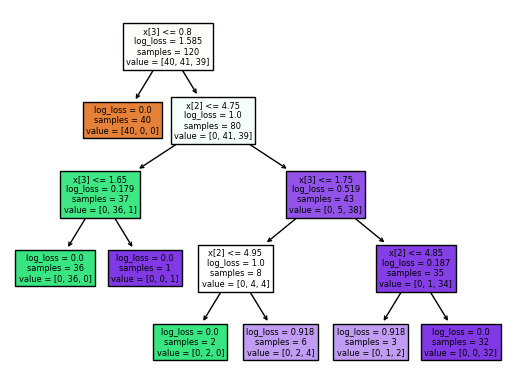

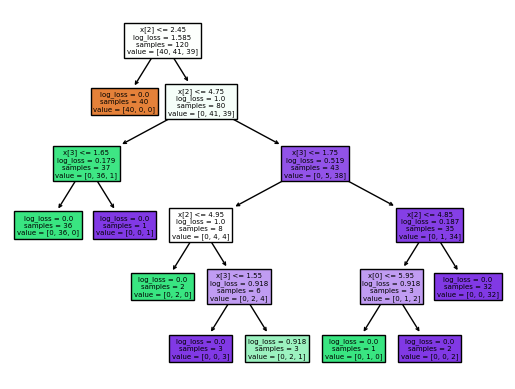

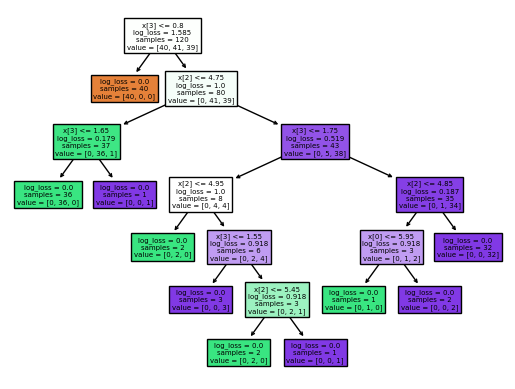

In [18]:
max_depth = 7
for depth in range(1, max_depth):
    plt.figure()
    clf = DecisionTreeClassifier(max_depth=depth, criterion='log_loss').fit(X_train, y_train)
    plot_tree(clf, filled=True)
    plt.show()

Дерево решений разделяло наши данные таким образом, чтобы минимизировать целевую функцию потерь. В качестве функции потерь была выбрана $$\sum \limits_i (-y_i \log p_i - (1-y_i)\log (1-p_i)) \to \min.$$
И как можно заметить, на глубине 7 мы как раз и достигли нулевого значения целевой функции. 

Рассчитаем показатель accuracy.

In [19]:
y_pred = clf.predict(X_test)
accuracy_score = sum((y_pred==y_test).astype(float)) / y_test.size
accuracy_score

1.0

Посмотрим среднуюю точность на кросс-валидации.

In [20]:
cv=cross_val_score(clf, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print(np.mean(cv))

0.9533333333333334


Как можно видеть, на тестовой выборке результат оказался 1.0, а на кросс валидации 0.95. Данный результат достаточно хорош, поскольку мы зайдествовали всего одно дерево решений, то есть использовали достаточно простую модель, причем достаточно малой глубины.

Построим гистограмму важности признаков, чтобы увидеть, какой из признаков оказал большее влияние на результаты классификации.

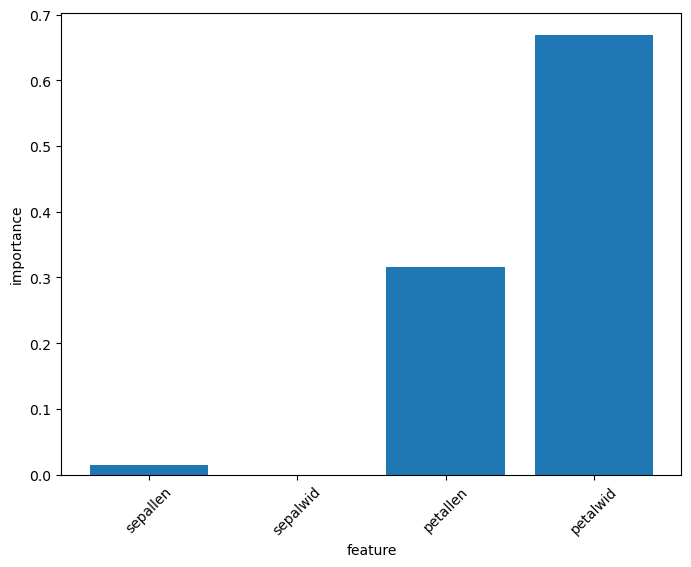

In [22]:
feature_importances = clf.feature_importances_
plt.figure(figsize=(8, 6))
plt.bar(range(X.shape[1]), feature_importances, align="center")
plt.xticks(range(X.shape[1]), ['sepallen', 'sepalwid', 'petallen', 'petalwid'], rotation=45)
plt.xlabel("feature")
plt.ylabel("importance")
plt.show()

Как модно видеть, набольшее влияние оказали признаки petallen и petalwid. В свою оередь, признак sepalwid никоим образом не повлиял на принятие дерево решений. Это логично, поскольку, как мы выясинил раньше, по переменным sepallen и sepalwid признаки очень плохо разделимы.

# Вывод

Все рассмотренные выше алгоритмы справились с задачей классификации с достаточно высокой точностью. Таким образом, на практике следует выбрать тот алгоритм, который по результатам анализа показал себя лучше других, при этом является наиболее простым. В нашем случае для дальнейшей классификации подобных данных мы можем взять алгоритмы линейного дискриминантного анализа и k ближайших соседей.